In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor

%matplotlib inline

In [2]:
# Importing data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
print(train_data.shape)
print(test_data.shape)

(6368, 15)
(3430, 14)


In [3]:
# Loading first 5 records of training data
train_data.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,6785.701362
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,13028.917824
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,906.553935


Product_id -> unique ID of each product

Stall_no -> Represents the number of stalls in the carnival (1-50)

instock_date -> Represents the date and time on which the product was bought

Market_Category -> Represents the different market categories that the products belong to

Customer_name -> Represents the names of the customers

Loyalty_customer -> Represents if a customer is a loyal customer

Product_Category -> Represents the 10 different product categories that the products belong to

Grade -> Represents the quality of products

Demand -> Represents the demand for the products being sold at the carnival

Discount_avail -> Represents whether a product is being sold at a discount or not

charges_1 -> Represents the types of charges applied on the products in the carnival

charges_2 (%) -> Represents the types of charges applied on the products in the carnival

Minimum_price -> Represents the minimum price of a product

Maximum_price -> Represents the maximum price of a product

Selling_Price -> Represents the selling price of the product in the carnival (Target Column)

In [4]:
# Null Values in training set
null_values = train_data.isnull().sum()
n = len(train_data)
train_null_values= pd.DataFrame({"null_values":null_values,"Percentage":np.round(100*null_values/n,2)}).sort_values(by="Percentage", ascending=False)
train_null_values.head(8)

,null_values,Percentage
Maximum_price,343,5.39
Customer_name,211,3.31
charges_2 (%),205,3.22
charges_1,198,3.11
Selling_Price,41,0.64
Discount_avail,38,0.60
Minimum_price,38,0.60
Stall_no,5,0.08


In [5]:
# Null Values in test set
null_values = test_data.isnull().sum()
n = len(test_data)
test_null_values= pd.DataFrame({"null_values":null_values,"Percentage":np.round(100*null_values/n,2)}).sort_values(by="Percentage", ascending=False)
test_null_values.head(5)

,null_values,Percentage
Customer_name,53,1.55
charges_1,36,1.05
Minimum_price,14,0.41
charges_2 (%),5,0.15
Stall_no,1,0.03


In Training set, Target column selling Price has 41 Null values so I am dropping those records

In [6]:
# Drop records that contains null values in target column
train_data.dropna(axis=0, subset=['Selling_Price'],inplace= True, how='all')

# After dropping 41 records that contains Null Values target column we are left with these null values
null_values = train_data.isnull().sum()
n = len(train_data)
train_null_values= pd.DataFrame({"null_values":null_values,"Percentage":np.round(100*null_values/n,2)}).sort_values(by="Percentage", ascending=False)
train_null_values.head(7)

,null_values,Percentage
Maximum_price,341,5.39
Customer_name,207,3.27
charges_2 (%),204,3.22
charges_1,198,3.13
Minimum_price,38,0.60
Discount_avail,37,0.58
Stall_no,5,0.08


In [7]:
train_data.describe()

,Stall_no,Market_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
count,6322.000000,6327.000000,6327.000000,6327.000000,6290.000000,6129.000000,6123.000000,6289.000000,5986.000000,6327.000000
mean,25.312243,199.100205,0.644065,50.922554,0.140064,264.657203,10.152866,3533.844490,6436.084698,4563.242592
std,14.331376,170.306880,1.025477,29.090574,0.347081,124.530510,4.317195,2193.700577,3717.051208,2979.102408
min,1.000000,0.000000,0.000000,1.000000,0.000000,100.000000,1.000000,1.000000,404.000000,-6062.470000
25%,13.000000,55.000000,0.000000,26.000000,0.000000,163.000000,7.000000,1882.000000,3922.250000,2450.005280
50%,25.000000,131.000000,0.000000,51.000000,0.000000,253.000000,10.000000,3164.000000,5638.500000,4210.384640
75%,37.000000,403.000000,2.000000,76.000000,0.000000,315.000000,14.000000,4697.000000,8126.750000,6167.643252
max,50.000000,471.000000,3.000000,100.000000,1.000000,649.000000,17.000000,17580.000000,58812.000000,22638.325941


**Here Selling Price is given in Negative also. Lets check these records**

In [8]:
print("No.of Records contain Selling Price as Negative is : ",len(train_data[train_data["Selling_Price"]<0]))
train_data[train_data["Selling_Price"]<0].sort_values("Selling_Price")

No.of Records contain Selling Price as Negative is :  14


,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
4244,SUDEHYGUZMA4GG74,4.0,2015-05-09 17:18:52.000,65,Conrad,Yes,Pet_care,2,87,0.0,191.0,11.0,4616.0,7291.0,-6062.470000
5551,TOPECGFUVZHKUFNN,31.0,2015-05-05 17:21:33.000,423,Jessica,No,Technology,0,79,0.0,529.0,6.0,3157.0,7563.0,-5833.297800
1115,DREED6FKBQXMDWGM,14.0,2015-05-06 16:21:38.000,55,NaN,Yes,Pet_care,0,77,0.0,169.0,7.0,3829.0,6083.0,-5077.185300
2486,BELEG6KUK6ZBFTZJ,14.0,2014-11-09 20:15:45.000,437,Aubrey,Yes,Child_care,0,19,0.0,331.0,17.0,4044.0,5395.0,-5058.014148
1348,WATEAYZJBFJXB4FZ,44.0,2015-03-01 00:31:35.000,256,Tristan,Yes,Repair,0,22,0.0,285.0,2.0,2873.0,6511.0,-4965.495150
1000,WATECHFU4QGFQEJG,15.0,2015-01-19 17:23:43.000,437,Audrey,No,Child_care,0,74,0.0,254.0,14.0,3885.0,5485.0,-4896.104400
2035,WSCEG2FYDYFDSVZ6,41.0,2014-10-29 12:46:30.000,236,Dylan,Yes,Hospitality,0,10,0.0,255.0,9.0,1320.0,7873.0,-4855.154436
3890,TOPDWSEVWXVQ4GXU,28.0,2015-05-06 14:20:59.000,1,Cesar,Yes,Cosmetics,0,1,0.0,208.0,16.0,2614.0,4891.0,-3966.103350
952,BOTEGYTZ2T6WUJMM,22.0,2014-10-18 23:59:24.000,23,Benjamin,Yes,Pet_care,2,12,0.0,102.0,5.0,1390.0,5665.0,-3630.896874
50,WSCEFUV4TVWT73ZB,3.0,2014-11-01 09:46:30.000,0,Henry,Yes,Child_care,0,27,0.0,289.0,16.0,2368.0,4231.0,-3584.795550


In [9]:
# Converting these values into Postitive
train_data["Selling_Price"] = np.abs(train_data["Selling_Price"])

In [10]:
# Combining train and test data
train_data["is_train"] = True
test_data["is_train"] = False
combine_data = pd.concat([train_data,test_data], axis=0, sort=False)
print(combine_data.shape)

(9757, 16)


In [11]:
# Unique Values in Each column
cols = ['Stall_no','Market_Category','Loyalty_customer','Product_Category','Grade','Discount_avail']
for i in np.arange(len(cols)):
    print("Unique value in column {} is {}".format(cols[i],sorted(combine_data[cols[i]].unique())))
    print("\n")

Unique value in column Stall_no is [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, nan]


Unique value in column Market_Category is [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 141, 143, 144, 146, 147, 148, 149, 150, 151, 152, 155, 156, 158, 162, 163, 164

In [12]:
# Filling Null values in Customer Name column
combine_data["Customer_name"].fillna("Unknown", inplace=True)

# Filling Null Values in Stall No. COlumn
combine_data["Stall_no"].fillna(combine_data["Stall_no"].median(), inplace= True)

# Creating a separate category for discount to fill na values
combine_data["Discount_avail"].fillna(2, inplace= True)

In [13]:
# Charges_1 depends on the product category. so fill na value in charges according to the median charges of each Product Category
dict_1 = combine_data.groupby("Product_Category")["charges_1"].median()
combine_data["charges_1"] = combine_data["charges_1"].fillna(combine_data["Product_Category"].apply(lambda x :dict_1.get(x)))

# Filling null values in Charges_2 according to median
combine_data["charges_2 (%)"].fillna(combine_data["charges_2 (%)"].median(), inplace=True)

In [14]:
# Fill NA values in column Minimum and Maximum
combine_data["Minimum_price"] = combine_data["Minimum_price"].fillna(value = combine_data["Maximum_price"].apply(lambda x :x/2))
combine_data["Maximum_price"] = combine_data["Maximum_price"].fillna(value = combine_data["Minimum_price"].apply(lambda x : x*2))

combine_data["Minimum_price"] = combine_data["Minimum_price"].fillna(value=combine_data["Minimum_price"].mean())
combine_data["Maximum_price"] = combine_data["Maximum_price"].fillna(value=combine_data["Maximum_price"].mean())

In [15]:
combine_data.dtypes

Product_id           object
Stall_no            float64
instock_date         object
Market_Category       int64
Customer_name        object
Loyalty_customer     object
Product_Category     object
Grade                 int64
Demand                int64
Discount_avail      float64
charges_1           float64
charges_2 (%)       float64
Minimum_price       float64
Maximum_price       float64
Selling_Price       float64
is_train               bool
dtype: object

In [16]:
# Changing datatype of columns
combine_data["Stall_no"]  = combine_data["Stall_no"].astype(np.int32)
combine_data["Discount_avail"] = combine_data["Discount_avail"].astype(np.int32)

# One Hot Encoding for Discount column
combine_data = pd.get_dummies(data=combine_data, columns=['Discount_avail'])

In [17]:
combine_data["Loyalty_customer"].replace({"No ":0,"Yes":1}, inplace=True)

In [18]:
# Making train and test data separate
train_data = combine_data[combine_data["is_train"]== True]
test_data = combine_data[combine_data["is_train"]== False]

In [19]:
train_data.sort_values("Minimum_price").head(5)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,is_train,Discount_avail_0,Discount_avail_1,Discount_avail_2
5431,NKCEA4CAPHDH5TJT,13,2015-09-24 16:22:19.000,29,Asiyah,0,Home_decor,0,71,206.0,15.0,1.0,2.0,1357.537500,True,1,0,0
117,TSHEBSFAYNFJY6ZY,2,2016-03-30 21:02:09.000,255,Edwardo,0,Home_decor,2,32,280.0,10.0,124.0,604.0,642.749100,True,1,0,0
574,SNDE7BYJPKRZEZER,36,2016-03-24 04:42:23.000,60,Kashmere,1,Organic,3,65,146.0,8.0,126.0,503.0,456.142500,True,1,0,0
1742,WATE4S5RZZY6ZCSA,25,2016-03-28 21:39:51.000,60,Rynn,1,Organic,3,92,111.0,5.0,172.0,2609.0,1480.568320,True,1,0,0
2963,WATDA5ZAWCTQHAY4,17,2016-03-28 21:59:40.000,60,Erich,1,Cosmetics,3,62,215.0,17.0,181.0,2634.0,241.296165,True,0,1,0


**Here I am going to drop first record with index no 5431 where selling price is very different as compared to Minimum and maximum price**

In [20]:
train_data.drop(5431, axis=0, inplace=True)

C:\Users\babit\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
train_data.sort_values("Maximum_price").head(5)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,is_train,Discount_avail_0,Discount_avail_1,Discount_avail_2
2393,CRTECN2QUHGCHPEB,39,2015-09-24 16:23:58.000,436,Philomena,0,Fashion,0,82,369.0,11.0,253.0,404.0,687.810816,True,1,0,0
5121,MUGE6A5HVZYHMHKW,32,2015-09-22 16:27:02.000,460,Maddex,1,Cosmetics,3,56,206.0,17.0,320.0,411.0,568.458432,True,1,0,0
618,DREE664ZRNGWSDAA,35,2015-09-22 14:20:35.000,460,Tegan,1,Hospitality,3,94,214.0,10.0,257.0,414.0,541.922304,True,1,0,0
5843,SHOEJKRFZ5B2AZZZ,4,2015-09-22 13:26:00.000,460,Ashleigh,0,Home_decor,3,83,273.0,15.0,291.0,420.0,619.971968,True,1,0,0
5158,SHOE2MCJC5DUUBTY,34,2015-09-22 14:28:27.000,460,Bailey,1,Child_care,3,44,317.0,16.0,283.0,420.0,664.778016,True,1,0,0


In [22]:
train_data.sort_values("Selling_Price").head(5)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price,is_train,Discount_avail_0,Discount_avail_1,Discount_avail_2
4398,CLTEJ5ZZGWBAZUWR,20,2015-05-09 13:21:38.000,447,Johan,1,Pet_care,0,76,197.0,11.0,4052.0,4817.0,4.000000,True,1,0,0
2163,CLTEHE9FKGAZSNXR,5,2015-05-05 15:13:23.000,283,Riley,1,Educational,0,19,113.0,13.0,1891.0,5090.0,36.000000,True,1,0,0
3926,BRAE7YF6YZHQNQND,25,2015-08-19 17:36:09.000,62,Unknown,1,Organic,0,63,118.0,9.0,245.0,626.0,82.252665,True,0,1,0
5566,ACCEGZ66HG5DH7ZH,28,2016-02-22 00:57:42.000,163,Natalynn,0,Organic,0,74,113.0,9.0,321.0,564.0,82.551150,True,0,1,0
2299,BRAECTFYUXFSVZHE,17,2015-08-18 19:08:35.000,23,Unknown,1,Pet_care,0,76,130.0,2.0,294.0,593.0,85.178115,True,0,1,0


**Here I am going to remove first two records that belongs to index no. 4398 and 2163 because here Selling price value is very differnt from Minimum and Maximum Value**

In [23]:
train_data.drop([2163,4398], axis=0, inplace=True)

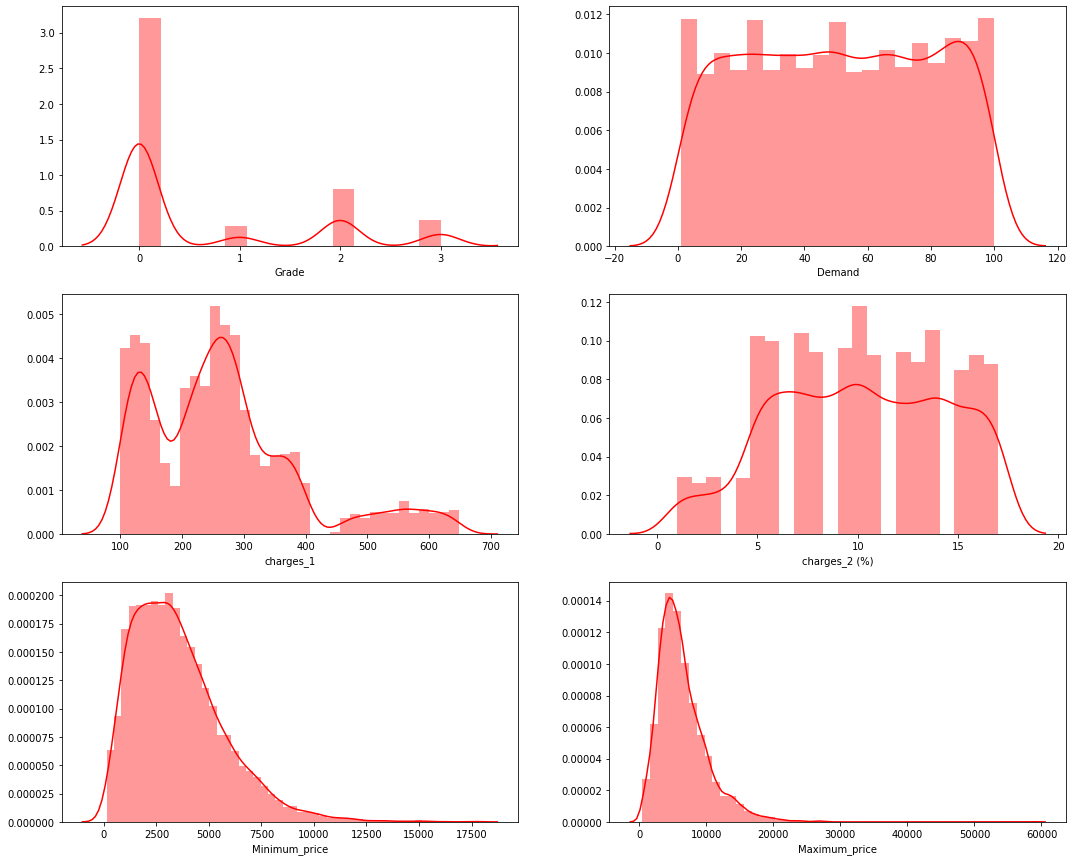

In [24]:
# Continuous Columns
k=0
cont_cols = ['Grade','Demand', 'charges_1', 'charges_2 (%)', 'Minimum_price','Maximum_price']
fig, ax = plt.subplots(3,2, figsize=(18,15))
for i in np.arange(3):
    for j in np.arange(2):
        sns.distplot(train_data[cont_cols[k]], ax=ax[i][j], color="red")
        k+=1
plt.show()   

Data in Minimum_Price and Maximim_Price is right Skewed distributed

In [25]:
train_data["Minimum_price"] = np.log1p(train_data["Minimum_price"])
train_data["Maximum_price"] = np.log1p(train_data["Maximum_price"])
train_data["Selling_Price"] = np.log1p(train_data["Selling_Price"])

test_data["Minimum_price"] = np.log1p(test_data["Minimum_price"])
test_data["Maximum_price"] = np.log1p(test_data["Maximum_price"])

C:\Users\babit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\babit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\babit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

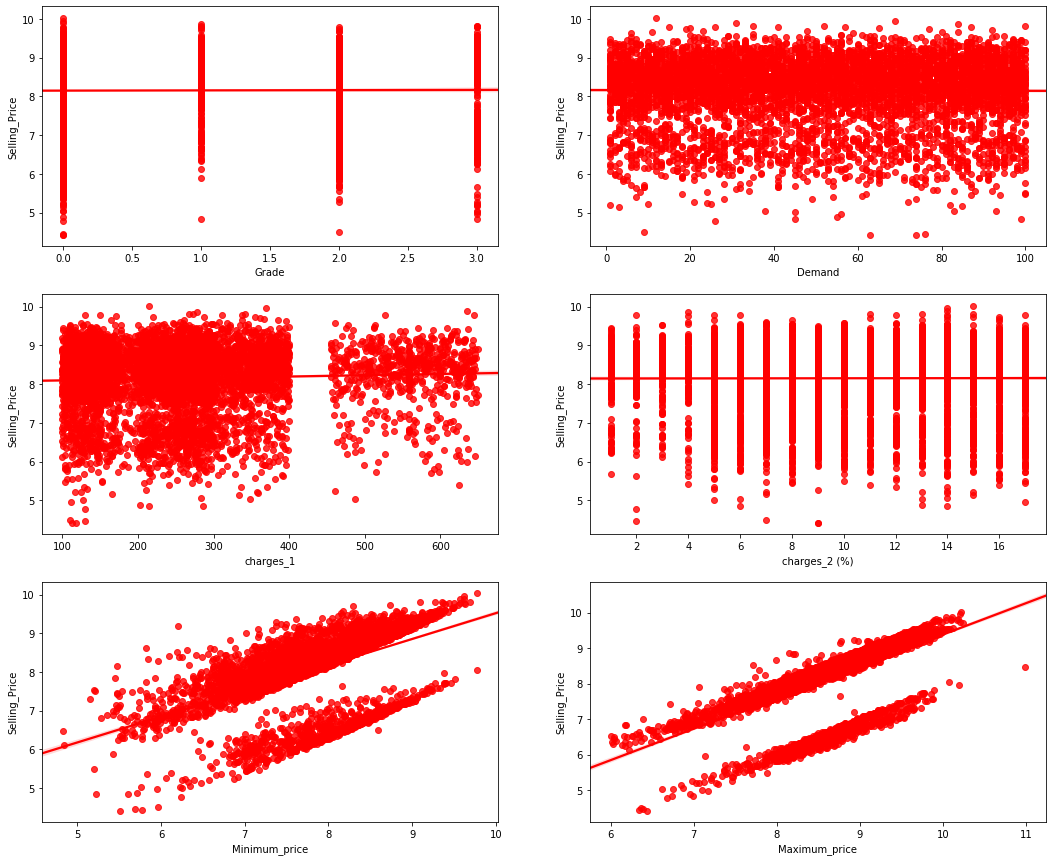

In [26]:
# Continuous column with Target column
k=0
cont_cols = ['Grade','Demand', 'charges_1', 'charges_2 (%)', 'Minimum_price','Maximum_price']
fig, ax = plt.subplots(3,2, figsize=(18,15))
for i in np.arange(3):
    for j in np.arange(2):
        sns.regplot(x =train_data[cont_cols[k]],y=train_data["Selling_Price"], ax=ax[i][j], color="red")
        k+=1
plt.show()   

In [27]:
# Correlation value between target column and Continuous column
for i in np.arange(len(cont_cols)):
    print("Correlation value between Target column and {} is {}".format(cont_cols[i],train_data[cont_cols[i]].corr(train_data["Selling_Price"])))

Correlation value between Target column and Grade is 0.007275836843822401
Correlation value between Target column and Demand is -0.006490416609915815
Correlation value between Target column and charges_1 is 0.048190302365586524
Correlation value between Target column and charges_2 (%) is 0.003020472660957188
Correlation value between Target column and Minimum_price is 0.556881578587164
Correlation value between Target column and Maximum_price is 0.6198180423579303


We Can see from the above graph that there is no correlation of Grade , Demand ,Charges_2 with Target column . So I am not considering these column for model building

### EDA - CATEGORICAL COLUMNS

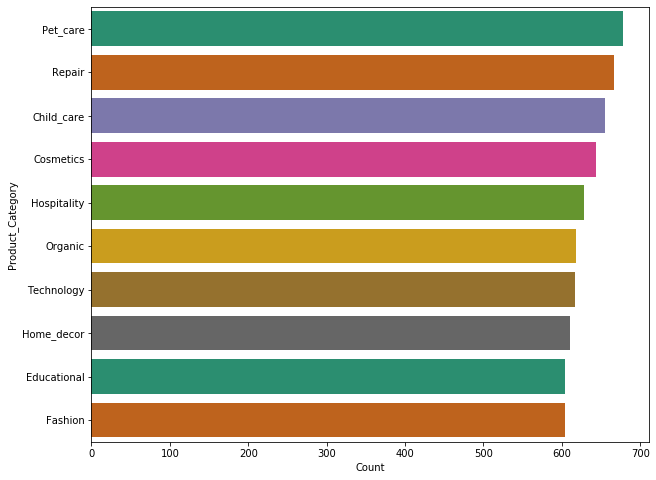

In [29]:
plt.figure(figsize = (10,8))
product_category = train_data["Product_Category"].value_counts().reset_index()
product_category.columns = ["Product_Category","Count"]
_ = sns.barplot(x = product_category["Count"], y=product_category["Product_Category"], palette="Dark2")

Each Product Category has almost equal no. of records

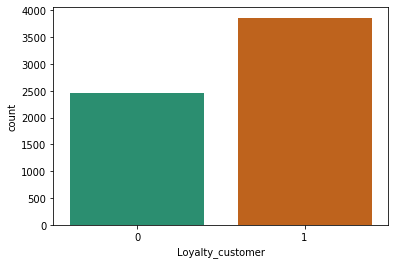

In [30]:
_ = sns.countplot(train_data["Loyalty_customer"], palette="Dark2")

No. of records of Customer with Loyalty are more as compared to customer with no loyalty

### Separate Feature and Target Column

In [31]:
X_train = train_data.drop(labels=['Product_id','instock_date','Customer_name','Selling_Price','is_train','Demand','charges_2 (%)','Discount_avail_2','Market_Category',"Grade",'Loyalty_customer'], axis=1)
X_test = test_data.drop(labels=['Product_id','instock_date','Customer_name','Selling_Price','is_train','Demand','charges_2 (%)','Discount_avail_2','Market_Category',"Grade",'Loyalty_customer'], axis=1)
y_train =  (train_data["Selling_Price"])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(6324, 7)
(3430, 7)
(6324,)


In [32]:
X_train.head()

,Stall_no,Product_Category,charges_1,Minimum_price,Maximum_price,Discount_avail_0,Discount_avail_1
0,37,Fashion,376.0,8.001020,8.458292,1,0
1,38,Fashion,397.0,8.922125,9.245032,1,0
2,9,Child_care,250.0,8.657477,8.896999,1,0
3,50,Educational,144.0,8.535230,9.943429,1,0
4,7,Repair,211.0,7.796058,9.133675,0,1


### Cat Boost

In [ ]:
# CAT BOOST with Kfold
from sklearn.model_selection import KFold

training_acuracy = 0
validation_accuracy = 0
test_accuracy = {}
cat_columns = ['Product_Category']

k_fold = KFold(n_splits=5,shuffle=True, random_state=101)
cat_boost = CatBoostRegressor(iterations=600, learning_rate=0.05, random_state=101,max_depth=5, colsample_bylevel=1, cat_features=cat_columns)
for index , (train_index, validation_index) in enumerate(k_fold.split(X_train, y_train)):
    print("K_FOLD :", index)
    X_train_ , X_validation = X_train.iloc[train_index], X_train.iloc[validation_index]
    y_train_ , y_validation = y_train.iloc[train_index], y_train.iloc[validation_index]
    
    cat_boost.fit(X_train_, y_train_)
    
    y_pred_train = np.expm1(cat_boost.predict(X_train_))
    y_pred_validation = np.expm1(cat_boost.predict(X_validation))
    y_pred_test = np.expm1(cat_boost.predict(X_test))
        
    training_acuracy += np.maximum(0,(100-(np.sqrt(mean_squared_log_error(y_train_, y_pred_train)))))
    validation_accuracy +=  np.maximum(0,(100-(np.sqrt(mean_squared_log_error(y_validation, y_pred_validation)))))
    test_accuracy[index] = y_pred_test

In [42]:
print("Accuracy on training set ",training_acuracy/5)
print("Accuracy on validation set ",validation_accuracy/5)

Accuracy on training set  94.00907179611616
Accuracy on validation set  94.00944395784484


In [43]:
summ = test_accuracy[0] + test_accuracy[1] + test_accuracy[2] + test_accuracy[3] + test_accuracy[4]
prediction =(summ/5)

In [44]:
sample_submission["Product_id"] = test_data["Product_id"]
sample_submission["Selling_Price"] = prediction
sample_submission.to_csv("sample_submission.csv", index=False)